In [1]:
# various import statements
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
from torch.optim import Adam
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
import pyro.optim
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.ops.indexing import Vindex
import pyro.contrib
import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
foo='hello'
bar='world'
import os
import sklearn
from sklearn import cluster
import pandas as pd
import re
import scanpy as sc
print(f"{foo=} {bar=}")
from torch import exp
from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))
sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')
    

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


foo='hello' bar='world'


In [2]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import plate_modules
from plate_modules import *

import importlib
plate_modules=importlib.reload(plate_modules)
from plate_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *



In [3]:
smoke_test=False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device="cpu"


cuda:0


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/scratch/fast/13910369/ipykernel_6516/819467349.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  species_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['species'].cat.codes).long(),num_classes=len(adata.obs['species'].cat.categories)).float()
/scratch/fast/13910369/ipykernel_6516/819467349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

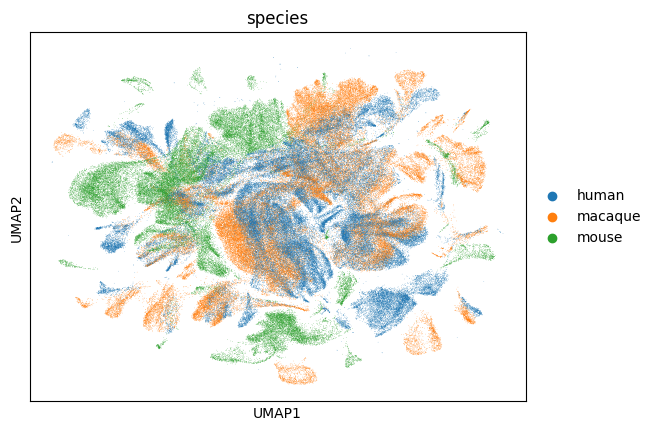

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

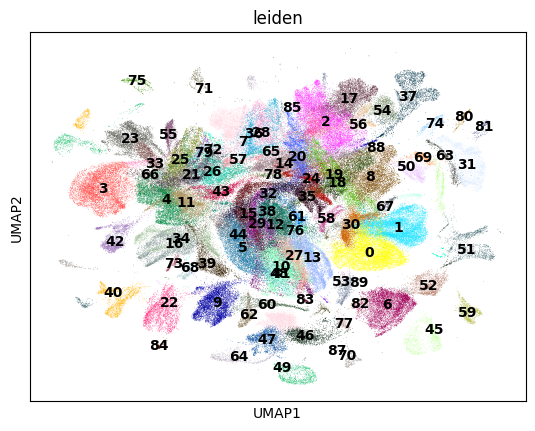

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

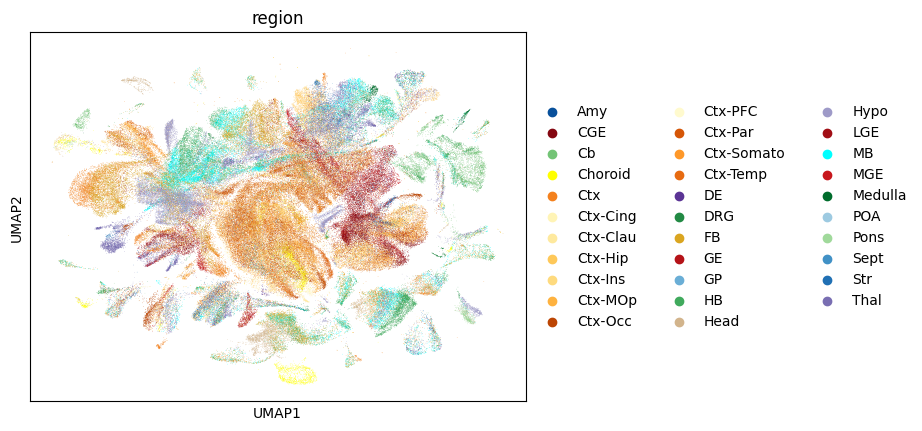

In [4]:
#adata=sc.read(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvM_900k_RPCA_clusters.h5ad'))
adata=sc.read(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part1.h5ad'))

species_arg=adata.obs['species'].cat.codes
species_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['species'].cat.codes).long(),num_classes=len(adata.obs['species'].cat.categories)).float()

adata.uns['batch_cats']=dict(zip([str(x) for x in adata.obs['batch_name'].cat.categories],[str(x) for x in sorted(set(adata.obs['batch_name'].cat.codes))]))
batch_arg=adata.obs['batch_name'].replace(adata.uns['batch_cats']).astype(int)
batch_values=torch.nn.functional.one_hot(torch.tensor(adata.obs['batch_name'].replace(adata.uns['batch_cats']).astype(int)).long(),
                                         num_classes=len(adata.uns['batch_cats'].keys())).float()


adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]#.todense()
#adata=adata[np.random.choice(adata.obs.index,100000,replace=False),:]
#sc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",subset=True)

adata=adata[~adata.obs.general_region.isin(['Cultured']),:]
adata=adata[~adata.obs.batch_name.str.contains('P10'),:]
#adata=adata[adata.obs['general_region'].isin(['bn','cp','ctx','ge']),:]

adata.obs['species']=adata.obs['species'].astype('category')
adata.obsm['X_original_umap']=adata.obsm['X_umap']
adata.obs['n_counts']=adata.X.sum(1)


In [7]:
samplegroups={'FB':'vt',
'bn':'vt',
'ctx':'ctx',
'cp':'vt',
'de':'de',
'ge':'vt',
'h':'vt',
'hb':'hb',
'mb':'mb'}
adata.obs['sample_region']=adata.obs['general_region'].replace(samplegroups)
adata.obs['region_species']=adata.obs['sample_region'].astype(str)+'_'+adata.obs['species'].astype(str)


# Put everything together

In [485]:
# Packages the antipode model and guide as a PyTorch nn.Module

class ANTIPODE(nn.Module):
    """
    ANTIPODE is a variational inference model that is developed for the analysis and 
    categorization of cell types across evolution based on single-cell data. 

    Parameters:
    num_var (int): Number of variables (features) in the dataset.
    l_loc (float): The location parameter for the length scale of the Gaussian Process.
    l_scale (float): The scale parameter for the length scale of the Gaussian Process.
    level_sizes (list of int, optional): Sizes of each level in the model's hierarchical structure. 
                                         Defaults to [1, 10, 20, 50].
    num_latent (int, optional): Number of latent dimensions. Defaults to 10.
    alpha (float, optional): The Dirichlet concentration parameter. Defaults to 0.01.
    scale_factor (float, optional): Scaling factor for data normalization. Defaults to 1.0.
    num_species (int, optional): Number of species (or groups) in the dataset. Defaults to 1.
    num_batch (int, optional): Number of batches to correct for in the data. Defaults to 1.
    prior_scale (float, optional): Scale of the laplace prior distributions. Defaults to 100.
    tree_approx (bool, optional): Flag to indicate whether to use a tree approximation. Defaults to False.
    bi_depth (int, optional): Depth of the tree for the approximation of batch by identity effects. Defaults to 2.

    """
    def __init__(self, num_var, l_loc, l_scale,level_sizes=[1,10,20,50],
                 num_latent=10, alpha=0.01, scale_factor=1.0,
                 num_species=1,num_batch=1,prior_scale=100,
                 decay_function=None,bi_depth=2,num_batch_embed=10):
        self.num_var = num_var
        self.num_species = num_species
        self.num_batch = num_batch
        self.num_latent = num_latent
        self.scale_factor=scale_factor
        self.level_sizes=level_sizes
        self.num_labels = np.sum(self.level_sizes)
        self.level_indices=np.cumsum([0]+self.level_sizes)
        #how deep in the tree should batch by identity be accounted for
        self.bi_depth=bi_depth
        self.num_bi_depth=sum(self.level_sizes[:self.bi_depth])
        self.num_batch_embed=num_batch_embed
        self.max_strictness=1.
        self.decay_function=decay_function

        # The next two hyperparameters determine the prior over the log_count latent variable `l`
        self.l_loc = l_loc
        self.l_scale = l_scale

        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.species_plate=pyro.plate('species_plate',self.num_species,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)
        self.bi_depth_plate=pyro.plate('bi_depth_plate',self.num_bi_depth,dim=-2)
       
        self.tree_edges=TreeEdges(self,straight_through=True)
        self.tree_convergence=TreeConvergence(self,strictness=1.)        
        self.z_transform=null_function#centered_sigmoid#torch.special.expit
        
        super().__init__()
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        self.prior_scale=prior_scale


    def model(self, s=None,species=None,batch=None,y1=None):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)     
        with poutine.scale(scale=self.scale_factor):
            level_edges=self.tree_edges.model_sample(s,approx=self.approx)

    
    # The guide specifies the variational distribution
    def guide(self, s=None, species=None,batch=None,y1=None):
        pyro.module("antipode", self)
        with poutine.scale(scale=self.scale_factor):
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx) 



In [561]:
class RelaxedQuantizeCategorical(torch.autograd.Function):
    temperature = None  # Default temperature
    epsilon = 1e-10    # Default epsilon

    @staticmethod
    def set_temperature(new_temperature):
        RelaxedQuantizeCategorical.temperature = new_temperature

    @staticmethod
    def set_epsilon(new_epsilon):
        RelaxedQuantizeCategorical.epsilon = new_epsilon

    @staticmethod
    def forward(ctx, soft_value):
        temperature = float(RelaxedQuantizeCategorical.temperature)
        epsilon = RelaxedQuantizeCategorical.epsilon
        uniforms = clamp_probs(
            torch.rand(soft_value.shape, dtype=soft_value.dtype, device=soft_value.device)
        )
        gumbels = -((-(uniforms.log())).log())
        scores = (soft_value + gumbels) / temperature
        outs = scores - scores.logsumexp(dim=-1, keepdim=True)
        outs = outs.exp()
        outs = outs + epsilon  # Use the class variable epsilon
        hard_value = outs.log()#(outs / outs.sum(1, keepdim=True)).log()
        hard_value._unquantize = soft_value
        return hard_value

    @staticmethod
    def backward(ctx, grad):
        return grad


class ExpRelaxedCategoricalStraightThrough(Distribution):
    arg_constraints = {"probs": constraints.simplex, "logits": constraints.real_vector}
    support = (
        constraints.real_vector
    )  # The true support is actually a submanifold of this.
    has_rsample = True

    def __init__(self, temperature, probs=None, logits=None, validate_args=None, epsilon=1e-10):
        self._categorical = Categorical(probs, logits)
        self.temperature = temperature
        RelaxedQuantizeCategorical.set_temperature(temperature)
        RelaxedQuantizeCategorical.set_epsilon(epsilon)
        
        batch_shape = self._categorical.batch_shape
        event_shape = self._categorical.param_shape[-1:]
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(ExpRelaxedCategoricalStraightThrough, _instance)
        batch_shape = torch.Size(batch_shape)
        new.temperature = self.temperature
        new._categorical = self._categorical.expand(batch_shape)
        super(ExpRelaxedCategoricalStraightThrough, new).__init__(
            batch_shape, self.event_shape, validate_args=False
        )
        new._validate_args = self._validate_args
        return new

    def _new(self, *args, **kwargs):
        return self._categorical._new(*args, **kwargs)

    @property
    def param_shape(self):
        return self._categorical.param_shape

    @property
    def logits(self):
        return self._categorical.logits

    @property
    def probs(self):
        print('probs')
        return self._categorical.probs

    def rsample(self, sample_shape=torch.Size()):
        outs=RelaxedQuantizeCategorical.apply(self.logits)
        return outs

    def log_prob(self, value):
        value = getattr(value, "_unquantize", value)
        K = self._categorical._num_events
        if self._validate_args:
            self._validate_sample(value)
        logits, value = broadcast_all(self.logits, value)
        score = logits 
        score = (score - score.logsumexp(dim=-1, keepdim=True)).sum(-1)
        print('logprob')
        return 0#score

class SafeAndRelaxedOneHotCategoricalStraightThrough(TransformedDistribution,TorchDistributionMixin):
    #Don't understand why these were broken (doesn't call straighthrough rsample in pyro)?
    arg_constraints = {"probs": constraints.simplex, "logits": constraints.real_vector}
    support = constraints.simplex
    has_rsample = True

    def __init__(self, temperature, probs=None, logits=None, validate_args=None):
        base_dist = ExpRelaxedCategoricalStraightThrough(
            temperature, probs, logits, validate_args=validate_args
        )
        super().__init__(base_dist, ExpTransform(), validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(SafeAndRelaxedOneHotCategoricalStraightThrough, _instance)
        return super().expand(batch_shape, _instance=new)

    @property
    def temperature(self):
        return self.base_dist.temperature

    @property
    def logits(self):
        return self.base_dist.logits

    @property
    def probs(self):
        return self.base_dist.probs


In [586]:
d=RelaxedOneHotCategoricalStraightThrough(temperature=0.1*torch.ones(1),logits=torch.ones(50))
print(d.sample([1]))
print(d.log_prob(d.sample([1])))
print(d.log_prob(torch.softmax(d.sample([1]),-1)))
print(d.log_prob(torch.softmax(torch.softmax(d.sample([1]),-1),-1)))
print(d.log_prob(safe_softmax(torch.ones(50))))

tensor([[3.5018e-05, 6.2772e-23, 1.4852e-18, 1.2244e-10, 2.5299e-23, 6.4315e-21,
         3.6311e-15, 4.3126e-23, 7.3703e-20, 1.9444e-25, 3.4312e-29, 7.4626e-25,
         2.3676e-14, 5.1521e-24, 6.0285e-20, 9.9323e-21, 6.1214e-08, 1.6347e-22,
         2.3223e-29, 2.9680e-24, 9.6113e-28, 1.8195e-23, 1.0229e-25, 1.9184e-23,
         1.7805e-13, 2.4588e-21, 4.4246e-25, 8.4656e-25, 2.7780e-22, 3.0209e-20,
         1.8079e-21, 5.9596e-17, 1.2419e-13, 2.8783e-19, 2.2257e-15, 4.5513e-22,
         4.5972e-26, 1.4019e-26, 3.2117e-12, 6.4292e-22, 2.0143e-20, 3.5306e-18,
         2.8049e-18, 2.5631e-22, 1.0499e-18, 8.1416e-21, 2.1320e-17, 1.4621e-21,
         1.3367e-25, 9.9996e-01]])
logprob
tensor([0.])
logprob
tensor([0.])
logprob
tensor([0.])
logprob
tensor([0.])


  4%|▍         | 1061/25000 [1:20:46<30:22:38,  4.57s/it]


In [563]:
d=dist.Normal(torch.zeros(1),torch.ones(1))
print(d.sample([1]))
print(d.log_prob(d.sample([1])))


tensor([[-0.5077]])
tensor([[-1.3683]])


In [564]:
try:
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [576]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/plate_version/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import plate_modules
from plate_modules import *

import importlib
plate_modules=importlib.reload(plate_modules)
from plate_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *


from torch.distributions.utils import clamp_probs

from pyro.distributions.torch import RelaxedBernoulli, RelaxedOneHotCategorical

class RelaxedOneHotCategoricalStraightThrough(RelaxedOneHotCategorical):
    def rsample(self, sample_shape=torch.Size()):
        soft_sample = super().rsample(sample_shape)
        soft_sample = clamp_probs(soft_sample)
        hard_sample = QuantizeCategorical.apply(soft_sample)
        hard_sample = hard_sample.clamp(min=torch.finfo(hard_sample.dtype).tiny)
        #hard_sample = (hard_sample / hard_sample.sum(1, keepdim=True))
        return hard_sample

    def log_prob(self, value):
        value = getattr(value, "_unquantize", value)
        return super().log_prob(value)


class QuantizeCategorical(torch.autograd.Function):
    @staticmethod
    def forward(ctx, soft_value):
        argmax = soft_value.max(-1)[1]
        hard_value = torch.zeros_like(soft_value)
        hard_value._unquantize = soft_value
        if argmax.dim() < hard_value.dim():
            argmax = argmax.unsqueeze(-1)
        return hard_value.scatter_(-1, argmax, 1)

    @staticmethod
    def backward(ctx, grad):
        return grad

class TreeEdges(MMB):
    def __init__(self, model,straight_through=True):
        super().__init__(model)
        self.straight_through=straight_through
        #self.cat_dist= model_distributions.SafeAndRelaxedOneHotCategoricalStraightThrough if straight_through else model_distributions.SafeAndRelaxedOneHotCategorical
        #self.cat_dist1=dist.Dirichlet
        self.cat_dist=RelaxedOneHotCategoricalStraightThrough#SafeAndRelaxedOneHotCategoricalStraightThrough#
        
    def model_sample(self,s=torch.ones(1),approx=False):
        if approx:
            temp=1.0
        else:
            temp=0.1
        level_edges=[pyro.sample('edges_sample_'+str(i),
                self.cat_dist(temperature=temp*torch.ones(1,device=s.device),logits=s.new_ones(self.model.level_sizes[i+1],self.model.level_sizes[i])).to_event(1))
                for i in range(len(self.model.level_sizes)-1)]
        return(level_edges)

    def make_params(self,s=torch.ones(1)):
        level_edges=[pyro.param('edges_'+str(i),
                0.01*torch.randn(self.model.level_sizes[i+1],self.model.level_sizes[i]).to(s.device),
                                constraint=constraints.interval(-20,20)) 
                for i in range(len(self.model.level_sizes)-1)]
        return(level_edges)

    def guide_sample(self,s=torch.ones(1),approx=False):
        level_edges=self.make_params(s)
        if approx:
            temp=1.0
        else:
            temp=0.1
        level_edges=[pyro.sample('edges_sample_'+str(i),
                self.cat_dist(temperature=temp*torch.ones(1,device=s.device,requires_grad=False),logits=level_edges[i]).to_event(1))
                for i in range(len(self.model.level_sizes)-1)]
        return(level_edges)



In [579]:
device='cuda'
num_var=adata.shape[1]
l_mean=np.log(adata.X.sum(1)).mean()
l_scale=np.log(adata.X.sum(1)).std()
batch_size=32
level_sizes=[1,25,75,225]
num_latent=200
num_labels=sum(level_sizes)
steps=0
max_steps=25000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(True)
decay_function=gen_linear_function(max_steps,15000)#gen_exponential_decay(5e-6)
# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_var=num_var, num_latent=num_latent,level_sizes=level_sizes,
                l_loc=l_mean, l_scale=l_scale,num_species=len(adata.obs['species'].unique()),
                num_batch=len(adata.obs['batch_name'].unique()),
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),
                bi_depth=2,decay_function=decay_function,prior_scale=100.,num_batch_embed=10)


# Setup an optimizer (Adam) and learning rate scheduler.
# We start with a moderately high learning rate (0.006) and
# reduce by a factor of 5 after 20 epochs.
scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})

# Setup a variational objective for gradient-based learning.
# Note we use TraceEnum_ELBO in order to leverage Pyro's machinery
# for automatic enumeration of the discrete latent variable y.
elbo = pyro.infer.JitTrace_ELBO(num_particles=1,strict_enumeration_warning=False)

svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

In [580]:
device='cuda'
antipode_model.train()
num_epochs=2

grad_check=False
from collections import defaultdict
param_d=defaultdict(list)

adata_toppath=os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM')
adata_paths=os.listdir(adata_toppath)
adata_paths=sorted([os.path.join(adata_toppath,x) for x in adata_paths if 'HvQvMall_part' in x])


antipode_model=antipode_model.to(device)
loss_tracker=[]
#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for adata_path in reversed(adata_paths[1:]):
        #pbar.write(adata_path)
        #TODO integrate SCVI dataloader with proper chunking
        #dataloader=make_dataloader(origdata=adata,adata_path=os.path.expanduser(adata_path),batch_size=batch_size)
        for x in dataloader:
            args=[y.to(device) for y in x]
            loss=svi.step(*args)
            steps+=1
            if steps<max_steps-1:
                scheduler.step()
            else:
                break
            pbar.update(1)
            loss_tracker.append(loss)
            if not done:
                done=True
                print('grad tracking')
                gradient_norms = defaultdict(list)
                for name, value in pyro.get_param_store().named_parameters():
                    value.register_hook(
                        lambda g, name=name: gradient_norms[name].append(g.norm().item())
                    )
            if steps%print_every == 0:
                # Tell the scheduler we've done one epoch.
                #print("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
                pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

  0%|          | 95/25000 [00:09<42:38,  9.74it/s]


logprob
logprob
logprob
logprob
logprob
logprob
logprob
logprob
logprob
logprob
logprob
logprob


  0%|          | 1/25000 [00:00<2:15:22,  3.08it/s]

grad tracking


  4%|▍         | 1059/25000 [00:16<04:45, 83.98it/s]

KeyboardInterrupt: 

<Axes: >

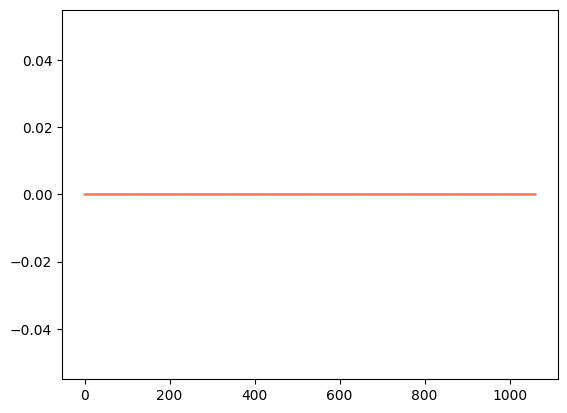

In [581]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



/scratch/fast/13910369/ipykernel_6516/3984978625.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


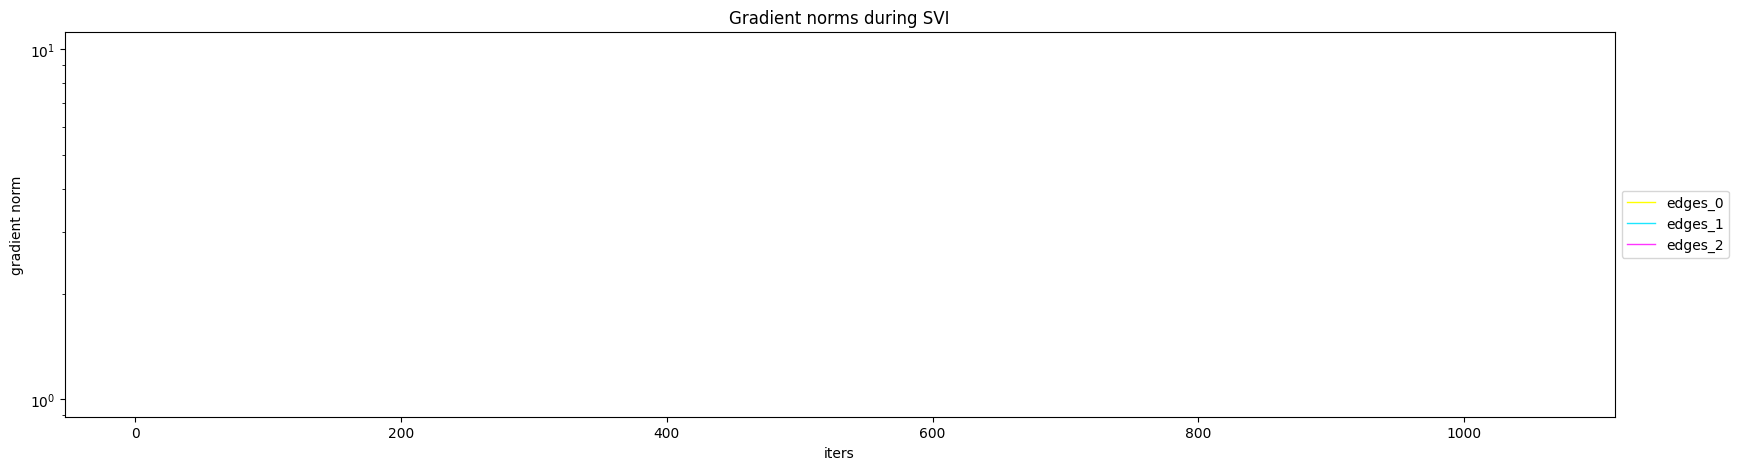

In [582]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [583]:
"""
antipode_model.dc_batch_encoder.cpu()
seaborn.histplot(antipode_model.dc_batch_encoder(torch.eye(batch_values.shape[1])).detach().cpu().numpy().flatten()[:10000],bins=100)
plt.show()
antipode_model.dc_batch_encoder.to(device)
"""

'\nantipode_model.dc_batch_encoder.cpu()\nseaborn.histplot(antipode_model.dc_batch_encoder(torch.eye(batch_values.shape[1])).detach().cpu().numpy().flatten()[:10000],bins=100)\nplt.show()\nantipode_model.dc_batch_encoder.to(device)\n'

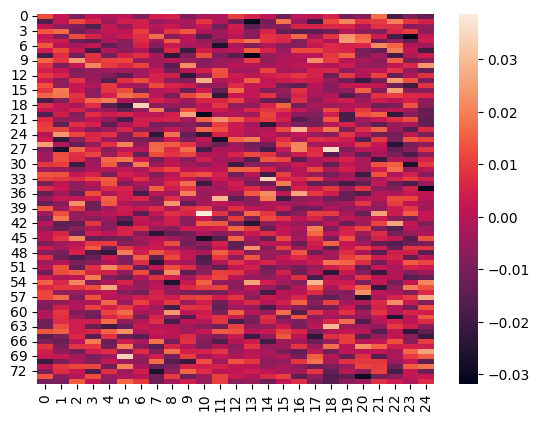

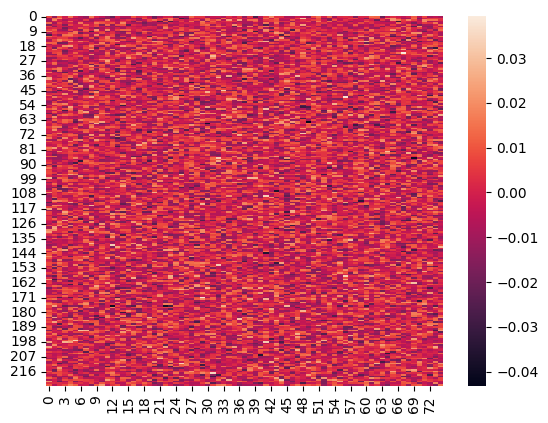

In [584]:
seaborn.heatmap(pyro.param('edges_1').cpu().detach().numpy())
plt.show()
seaborn.heatmap(pyro.param('edges_2').cpu().detach().numpy())
plt.show()

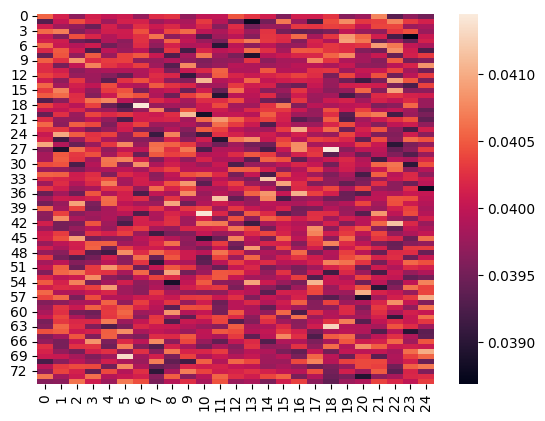

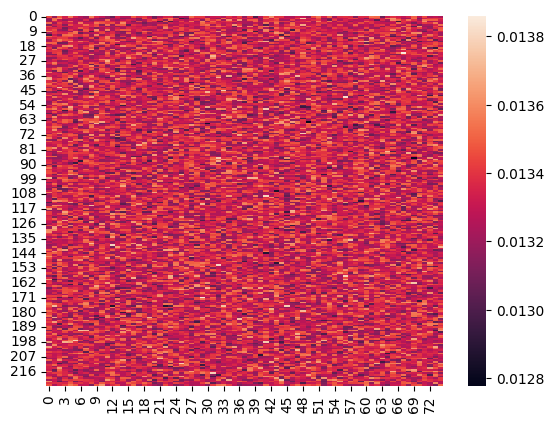

  4%|▍         | 1061/25000 [00:26<04:45, 83.98it/s]

In [585]:
seaborn.heatmap(torch.softmax(pyro.param('edges_1'),dim=-1).cpu().detach().numpy())
plt.show()
seaborn.heatmap(torch.softmax(pyro.param('edges_2'),dim=-1).cpu().detach().numpy())
plt.show()